In [1]:
 # Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [2]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [3]:
# First, we get the data
dataset = pd.read_csv('stock.csv', index_col='Date', parse_dates=['Date'])
dataset.tail()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2017-12-22,71.42,71.87,71.22,71.58,10979165,AABA
2017-12-26,70.94,71.39,69.63,69.86,8542802,AABA
2017-12-27,69.77,70.49,69.69,70.06,6345124,AABA
2017-12-28,70.12,70.32,69.51,69.82,7556877,AABA
2017-12-29,69.79,70.13,69.43,69.85,6613070,AABA


In [4]:
dataset.shape

(3019, 6)

In [5]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values
training_set.shape

(2768, 1)

In [6]:
test_set.shape

(251, 1)

In [7]:
dataset['2017'].loc[(dataset.High==40.25)]

C:\Users\VARUNS~1\AppData\Local\Temp/ipykernel_16680/3347853492.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  dataset['2017'].loc[(dataset.High==40.25)]


,Open,High,Low,Close,Volume,Name
Date,,,,,,
2017-01-04,39.0,40.25,38.92,40.06,11759453,AABA


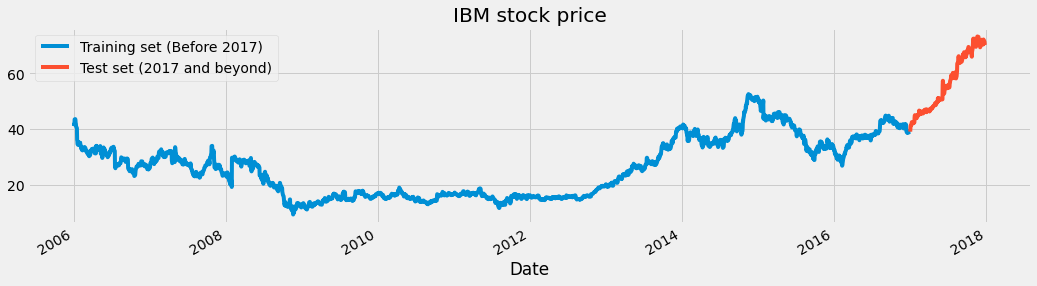

In [8]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [9]:
training_set.shape

(2768, 1)

In [10]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [11]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2768): 
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [22]:
X_train.shape, y_train.shape

((2708, 60, 1), (2708,))

In [23]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_train.shape

(2708, 60, 1)

In [13]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=20,batch_size=32)

Epoch 1/20
85/85 [==============================] - 14s 97ms/step - loss: 0.0178
Epoch 2/20
85/85 [==============================] - 7s 79ms/step - loss: 0.0083
Epoch 3/20
85/85 [==============================] - 7s 83ms/step - loss: 0.0064
Epoch 4/20
85/85 [==============================] - 7s 85ms/step - loss: 0.0048
Epoch 5/20
85/85 [==============================] - 7s 85ms/step - loss: 0.0041
Epoch 6/20
85/85 [==============================] - 7s 79ms/step - loss: 0.0041
Epoch 7/20
85/85 [==============================] - 7s 77ms/step - loss: 0.0035
Epoch 8/20
85/85 [==============================] - 7s 79ms/step - loss: 0.0033
Epoch 9/20
85/85 [==============================] - 6s 76ms/step - loss: 0.0030
Epoch 10/20
85/85 [==============================] - 7s 79ms/step - loss: 0.0028
Epoch 11/20
85/85 [==============================] - 6s 76ms/step - loss: 0.0027
Epoch 12/20
85/85 [==============================] - 6s 76ms/step - loss: 0.0026
Epoch 13/20
85/85 [=================

In [14]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [15]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [16]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 1s 27ms/step


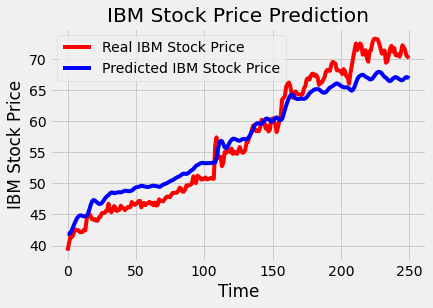

In [17]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [18]:
# Kaggle source https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook

In [19]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=10,batch_size=150)

Epoch 1/10


C:\Users\Varun Salunkhe\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


19/19 [==============================] - 9s 194ms/step - loss: 0.0837
Epoch 2/10
19/19 [==============================] - 4s 205ms/step - loss: 0.0257
Epoch 3/10
19/19 [==============================] - 4s 191ms/step - loss: 0.0057
Epoch 4/10
19/19 [==============================] - 4s 194ms/step - loss: 0.0034
Epoch 5/10
19/19 [==============================] - 4s 197ms/step - loss: 0.0031
Epoch 6/10
19/19 [==============================] - 4s 207ms/step - loss: 0.0030
Epoch 7/10
19/19 [==============================] - 4s 199ms/step - loss: 0.0030
Epoch 8/10
19/19 [==============================] - 4s 200ms/step - loss: 0.0028
Epoch 9/10
19/19 [==============================] - 4s 197ms/step - loss: 0.0029
Epoch 10/10
19/19 [==============================] - 4s 208ms/step - loss: 0.0025


# Inclass section - Make the RNN better